# **AURORA Dataset Overview**
## Master's Degree in Intelligent Systems
### University of the Balearic Islands
### Irving Perez Uribe
---

# AURORA Dataset Overview 🌊

This notebook provides an initial exploration of the AURORA dataset sample.  
We will:
- Review the directory structure
- Load and preview the multibeam echosounder and CTD data
- Visualize any available navigation coordinates (if present)

Dataset path: `../data/raw/aurora_dataset_sample/`
- ---

### Import libraries



In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Optional: better plots
plt.style.use('seaborn-v0_8-darkgrid')


## 📘 Notebook Overview

This notebook provides an initial exploration and preprocessing of the AURORA dataset, with a focus on the MBES (Multibeam Echosounder) and SSS (Side-Scan Sonar) data acquired by the Orat AUV.

We aim to:
- Understand what each variable in the dataset represents.
- Clarify the distinction between AUV depth and seafloor (bathymetric) depth.
- Prepare the data for fusion, visualization, and future machine learning tasks.


###  Explore Directory

In [2]:
base_path = "../data/raw/aurora_dataset_sample/JC125"
for root, dirs, files in os.walk(base_path):
    level = root.replace(base_path, '').count(os.sep)
    indent = ' ' * 2 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 2 * (level + 1)
    for f in files:
        print(f"{subindent}{f}")

JC125/
  autosub6000.urdf
  M86/
    multi-beam-echosounder-index.csv
    CTD/
      M086_CTD.csv
    multibeam_echosounder/
      raw/
        M0860005.all
  M87/
    side-scan-sonar/
      side-scan-sonar-index.csv
      xtf/
        DATA0000117.H-PU.xtf
    vertical-camera/
      images/
        result.png
      raw/
        Test48_13331848_13083843768642.raw
        Test48_13331848_13083844510668.raw
        Test48_13331848_13083845996668.raw
        Test48_13331848_13083848511669.raw
        Test48_13331848_13083857042672.raw
        Test48_13331848_13083861097673.raw
        Test48_13331848_13083861476673.raw
        Test48_13331848_13083861621673.raw


## Multibeam Echosounder (MBES) Data Load

**Objective:** Load the MBES index CSV file to inspect navigation, depth, and sensor data collected during the AUV's mission.

**Method:** Use `pandas` to read the dataset. Display the first few rows to examine column names and values.

**Clarification:** 
- The column `depth` refers to the vertical position of the AUV in the water column, measured by a pressure sensor.
- The column `altitude` refers to the distance between the AUV and the seabed, likely derived from sonar sensors.
- Therefore, the **actual bathymetric depth** (seafloor depth) can be computed as `depth + altitude`.


In [3]:
# Load MBES CSV
mbes_path = os.path.join(base_path, "M86", "multi-beam-echosounder-index.csv")
mbes_df = pd.read_csv(mbes_path)

# Display basic info
print("MBES shape:", mbes_df.shape)
display(mbes_df.head())


MBES shape: (36452, 140)


C:\Users\perez\AppData\Local\Temp\ipykernel_21608\1333535944.py:3: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,22,23,24,25,26,27,28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  mbes_df = pd.read_csv(mbes_path)


,Date,Time,Seconds,Latitude,Longitude,depth,altitude,Roll,Pitch,Heading,...,Veast14,Vnorth14,Vdown14,Verr14,Inten3_15,Inten15,Veast15,Vnorth15,Vdown15,Verr15
0,10-Aug-2015,16:30:00,-7958,50.333973,-7.711981,-0.421316,1000.000000,0.063879,-0.016162,0.083112,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10-Aug-2015,16:30:02,-7956,50.333973,-7.711983,-0.421316,1000.000000,0.03187,-0.023911,0.073164,...,NaN,NaN,NaN,NaN,0.000000,41.000000,NaN,NaN,NaN,NaN
2,10-Aug-2015,16:30:04,-7954,50.333973,-7.711986,-0.384176,1000.000000,-0.006109,-0.010786,0.067317,...,NaN,NaN,NaN,NaN,0.000000,41.000000,NaN,NaN,NaN,NaN
3,10-Aug-2015,16:30:06,-7952,50.333973,-7.711987,-0.421316,1000.000000,0.000227,0.009634,0.078348,...,NaN,NaN,NaN,NaN,0.000000,41.000000,NaN,NaN,NaN,NaN
4,10-Aug-2015,16:30:08,-7950,50.333973,-7.711989,-0.384464,1000.000000,0.037332,0.008186,0.092066,...,NaN,NaN,NaN,NaN,0.000000,41.000000,NaN,NaN,NaN,NaN


## Understanding MBES Columns

The MBES CSV contains time-stamped navigation and sensor data from the AUV mission. Some of the most important columns include:

- `depth`: Depth of the AUV from the sea surface, measured by a pressure sensor.
- `altitude`: Distance from the AUV to the seafloor, measured using sonar (likely MBES).
- `Roll`, `Pitch`, `Heading`: Orientation of the AUV.
- `Latitude`, `Longitude`: GPS coordinates of the AUV position.

We will use these to reconstruct the trajectory and compute seafloor depth.

## Cleaning Columns and Creating Timestamps

**Objective:** Ensure all column names are consistent and usable, and combine date and time into a single timestamp.

**Method:** Strip column names of whitespace, convert date + time strings into a `datetime` object. This will allow time-based analysis and plots.

**Result:** A new column `datetime` is added and can be used for sorting, filtering, and visualizing temporal changes.

In [4]:
# Load and clean MBES data
mbes_df = pd.read_csv(mbes_path)
mbes_df.columns = mbes_df.columns.str.strip()  # Clean column names

# Combine date and time
mbes_df['datetime'] = pd.to_datetime(mbes_df['Date'] + ' ' + mbes_df['Time'], errors='coerce')

C:\Users\perez\AppData\Local\Temp\ipykernel_21608\565701753.py:2: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,22,23,24,25,26,27,28,29,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  mbes_df = pd.read_csv(mbes_path)


In [5]:
mbes_df['depth'] = pd.to_numeric(mbes_df['depth'], errors='coerce')
mbes_df['altitude'] = pd.to_numeric(mbes_df['altitude'], errors='coerce')

## Estimating Bathymetry (Seabed Depth)

**Objective:** Compute the true depth of the seafloor by combining AUV depth and altitude.

**Method:** `seabed_depth = depth + altitude`. This represents the distance from the water surface to the seafloor.

**Note:** Always confirm units and directions (some systems report depth as negative values).

**Result:** This new value (`seabed_depth`) will be used in further analysis, including SSS alignment and ML feature creation.

### Understanding the Difference Between AUV Depth and Seafloor Depth

In the MBES dataset, the column `depth` refers to the depth of the Autonomous Underwater Vehicle (AUV) itself, measured from the sea surface. This value is typically obtained via a pressure sensor and represents the AUV's vertical position in the water column.

However, this value **does not represent the seafloor depth**.

To calculate the true **bathymetric depth** (i.e., the distance from the sea surface to the seafloor), we must take into account the AUV's height above the bottom. This is given by the `altitude` column, which measures the distance from the AUV to the seabed, typically obtained using a downward-looking sonar such as a multibeam echosounder.

### Bathymetric depth formula:

\[
Seafloor depth = AUV depth + Altitude
\]

This combined value gives an estimate of the actual seafloor topography and is what should be used when analyzing bathymetric terrain or training machine learning models on seafloor features.

In [6]:
mbes_df['seafloor_depth'] = mbes_df['depth'] + mbes_df['altitude']

In [7]:
mbes_df['Longitude'] = pd.to_numeric(mbes_df['Longitude'], errors='coerce')
mbes_df['Latitude'] = pd.to_numeric(mbes_df['Latitude'], errors='coerce')
mbes_df['seafloor_depth'] = pd.to_numeric(mbes_df['seafloor_depth'], errors='coerce')

In [8]:
mbes_clean = mbes_df.dropna(subset=['Longitude', 'Latitude', 'seafloor_depth'])

## MBES Track and Seafloor Visualization

The plot below shows the estimated seafloor depth along the AUV’s trajectory. We use color to represent depth variations, giving an early insight into the bathymetric features of the mission area.


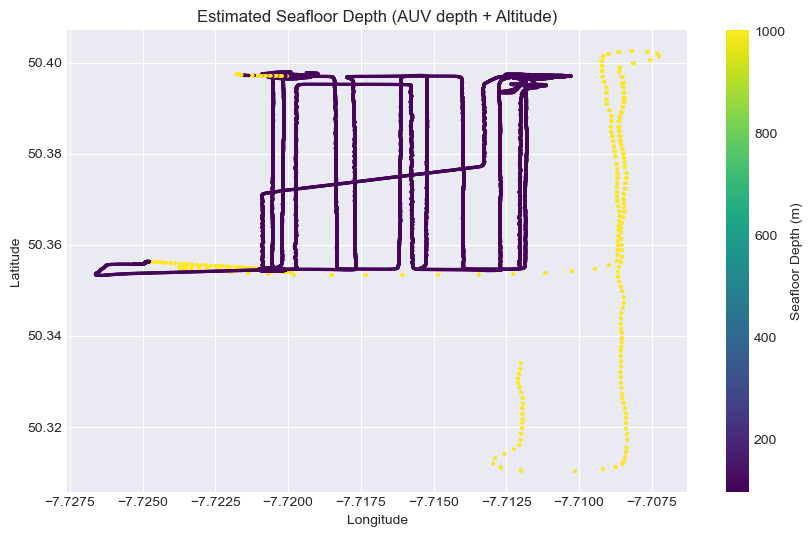

In [9]:
plt.figure(figsize=(10, 6))
plt.scatter(
    mbes_clean['Longitude'], 
    mbes_clean['Latitude'], 
    c=mbes_clean['seafloor_depth'], 
    cmap='viridis', 
    s=2
)
plt.colorbar(label='Seafloor Depth (m)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Estimated Seafloor Depth (AUV depth + Altitude)')
plt.grid(True)
plt.show()

### Load CTD Data

In [10]:
ctd_path = os.path.join(base_path, "M86", "CTD", os.listdir(os.path.join(base_path, "M86", "CTD"))[0])
ctd_df = pd.read_csv(ctd_path)
ctd_df.head()

,eTime;eTimeStart;T1;T2;C1;C2;Depth;DO;LSS;EH;rho1;rho2
0,10-Aug-2015 16:30:02;10-Aug-2015 16:30:01;0.00...
1,10-Aug-2015 16:30:03;10-Aug-2015 16:30:01;0.00...
2,10-Aug-2015 16:30:04;10-Aug-2015 16:30:01;0.00...
3,10-Aug-2015 16:30:05;10-Aug-2015 16:30:01;0.00...
4,10-Aug-2015 16:30:06;10-Aug-2015 16:30:01;0.00...


### Plot Navigation Path if Available

In [11]:
print(mbes_df[['Longitude', 'Latitude']].dtypes)

Longitude    float64
Latitude     float64
dtype: object


## Coordinate Cleaning for Latitude and Longitude

**Objective:** Convert latitude and longitude to numeric values and remove invalid entries.

**Method:** Use `pandas.to_numeric` to clean the columns, and drop rows with NaNs caused by corrupted or missing values.

**Result:** The cleaned coordinates can now be plotted on a map or used in geospatial operations.

In [12]:
mbes_df['Longitude'] = pd.to_numeric(mbes_df['Longitude'], errors='coerce')
mbes_df['Latitude'] = pd.to_numeric(mbes_df['Latitude'], errors='coerce')

In [13]:
# Check for NaNs
missing_data_ratio = mbes_df.isna().mean().sort_values(ascending=False)
display(missing_data_ratio.head(10))

# Basic statistics
print("Depth stats:")
print(mbes_df['seafloor_depth'].describe())
print("\nAltitude stats:")
print(mbes_df['altitude'].describe())

depth             0.000110
altitude          0.000110
seafloor_depth    0.000110
Longitude         0.000055
Latitude          0.000055
Time              0.000000
Seconds           0.000000
Roll              0.000000
Pitch             0.000000
Heading           0.000000
dtype: float64

Depth stats:
count    36448.000000
mean       211.930805
std        285.044678
min         95.768024
25%        106.868706
50%        108.068870
75%        111.843291
max       1001.743716
Name: seafloor_depth, dtype: float64

Altitude stats:
count    36448.000000
mean       152.097171
std        308.869625
min          1.720000
25%         14.847500
50%         49.897499
75%        109.083118
max       1000.000000
Name: altitude, dtype: float64


In [14]:
mbes_df.dropna(subset=['Longitude', 'Latitude'], inplace=True)

## MBES Navigation Path Visualization

**Objective:** Plot the AUV’s trajectory using latitude and longitude from the MBES dataset.

**Method:** Use `matplotlib` to draw a line plot of the vehicle’s path.

**Result:** A clear zigzag pattern is expected, representing typical seabed surveying motion. This helps verify spatial coverage of the data.

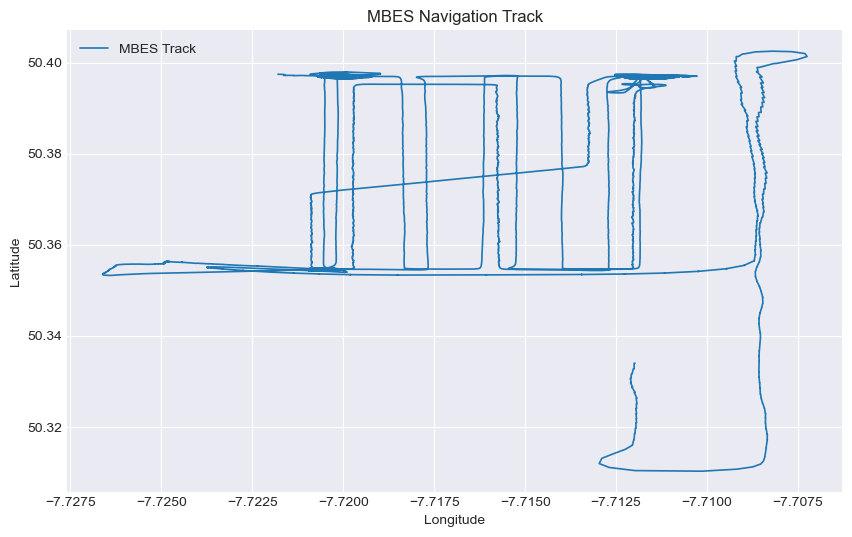

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(mbes_df['Longitude'], mbes_df['Latitude'], label='MBES Track', linewidth=1.2)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("MBES Navigation Track")
plt.legend()
plt.grid(True)
plt.show()

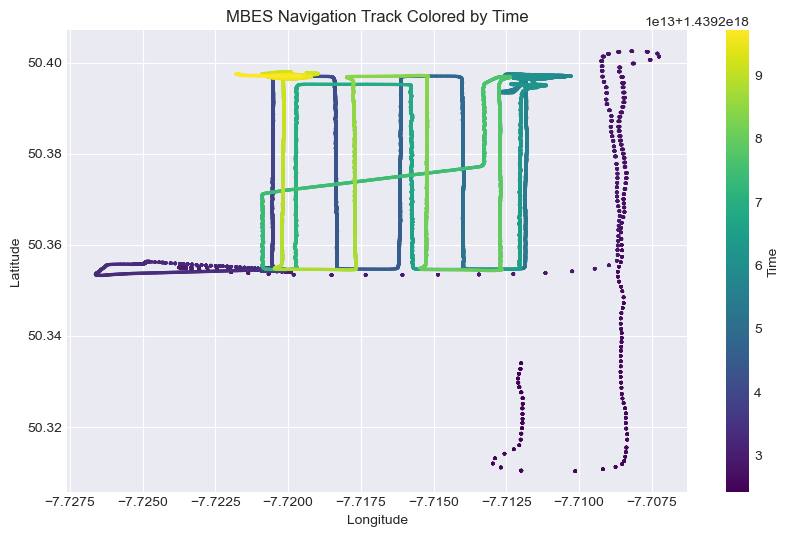

In [16]:
mbes_df['datetime'] = pd.to_datetime(mbes_df['datetime'])

plt.figure(figsize=(10, 6))
plt.scatter(
    mbes_df['Longitude'],
    mbes_df['Latitude'],
    c=mbes_df['datetime'].astype(int),
    cmap='viridis',
    s=2
)
plt.colorbar(label='Time')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("MBES Navigation Track Colored by Time")
plt.grid(True)
plt.show()

In [17]:
print(mbes_df['seafloor_depth'].dtype)

float64


In [18]:
mbes_df['seafloor_depth'] = pd.to_numeric(mbes_df['seafloor_depth'], errors='coerce')
mbes_df = mbes_df.dropna(subset=['seafloor_depth', 'Longitude', 'Latitude'])

In [19]:
print("Deleted lines after cleanning:", len(mbes_df))

Deleted lines after cleanning: 36448


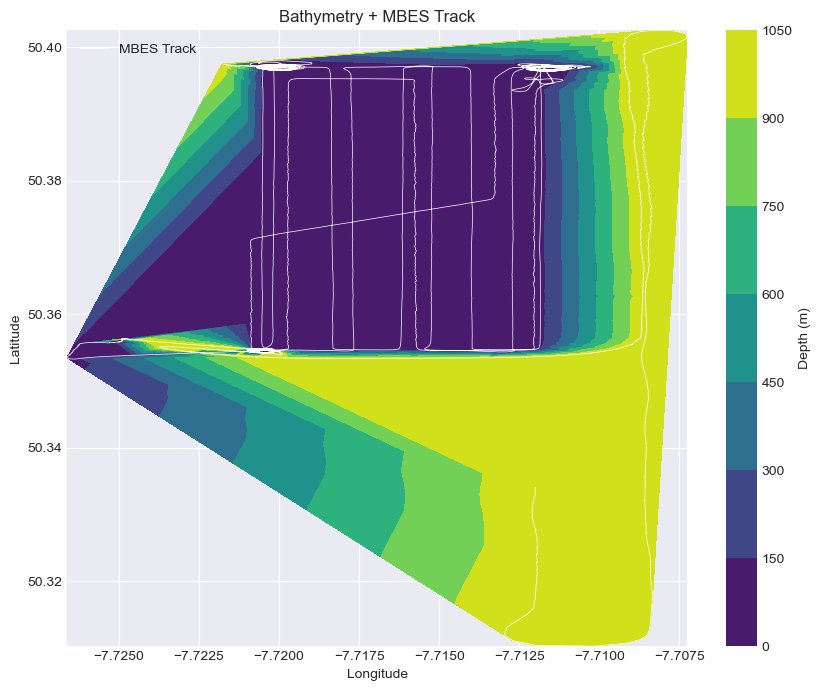

In [20]:
plt.figure(figsize=(10, 8))
plt.tricontourf(mbes_df['Longitude'], mbes_df['Latitude'], mbes_df['seafloor_depth'], cmap='viridis')
plt.plot(mbes_df['Longitude'], mbes_df['Latitude'], color='white', linewidth=0.5, label='MBES Track')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Bathymetry + MBES Track')
plt.colorbar(label='Depth (m)')
plt.legend()
plt.grid(True)
plt.show()

---
## Loading and Inspecting Side-Scan Sonar (SSS) Data

**Objective:** Load the sonar intensity index file and check available variables.

**Method:** Read CSV with `sep=';'` and rename relevant columns for clarity.

**Key Columns:**
- `Latitude`, `Longitude`: GPS position of sonar ping.
- `PortMean`: Mean intensity from the port side sonar (used as `intensity`).

**Result:** We now have georeferenced sonar intensity values, ready to be aligned with MBES data.

---

In [21]:
## Load the SSS data.
sss_path = r"D:\IrvingPU\UIB\TFM\Sonar-Data-Overlay-on-the-Orat-AUV\data\raw\aurora_dataset_sample\JC125\M87\side-scan-sonar\side-scan-sonar-index.csv"
sss_df = pd.read_csv(sss_path)

sss_df.head()

,Data;Time;Ping Number;File;Latitude;Longitude;Heading;Roll;Pitch;SoundVelocity;PortMin;PortMean;PortMax;StdBMin;StdBMean;StdBMax;
0,12/08/2015;09:04:35.670;117;DATA0000106.H-PU;5...
1,12/08/2015;09:04:37.010;11;DATA0000106.H-PU;50...
2,12/08/2015;09:04:37.170;12;DATA0000106.H-PU;50...
3,12/08/2015;09:04:37.340;13;DATA0000106.H-PU;50...
4,12/08/2015;09:04:37.510;14;DATA0000106.H-PU;50...


In [22]:
sss_df.columns

Index(['Data;Time;Ping Number;File;Latitude;Longitude;Heading;Roll;Pitch;SoundVelocity;PortMin;PortMean;PortMax;StdBMin;StdBMean;StdBMax;'], dtype='object')

In [23]:
sss_df = pd.read_csv(sss_path, sep=';')
sss_df.head()

,Data,Time,Ping Number,File,Latitude,Longitude,Heading,Roll,Pitch,SoundVelocity,PortMin,PortMean,PortMax,StdBMin,StdBMean,StdBMax,Unnamed: 16
0,12/08/2015,09:04:35.670,117,DATA0000106.H-PU,50.395279,-7.712078,-16.07,2.27,750.0,0.0,30.35,305.0,0.0,42.54,841.0,NaN,NaN
1,12/08/2015,09:04:37.010,11,DATA0000106.H-PU,50.395289,-7.712059,-16.21,2.43,750.0,0.0,30.06,251.0,0.0,41.70,753.0,NaN,NaN
2,12/08/2015,09:04:37.170,12,DATA0000106.H-PU,50.395289,-7.712059,-16.21,2.43,750.0,0.0,29.85,267.0,0.0,42.72,395.0,NaN,NaN
3,12/08/2015,09:04:37.340,13,DATA0000106.H-PU,50.395289,-7.712059,-16.21,2.43,750.0,0.0,30.45,254.0,0.0,41.38,448.0,NaN,NaN
4,12/08/2015,09:04:37.510,14,DATA0000106.H-PU,50.395289,-7.712059,-16.21,2.43,750.0,0.0,30.91,307.0,0.0,40.70,476.0,NaN,NaN


## Understanding Side-Scan Sonar (SSS) Data

The SSS data includes sonar intensity values recorded during the AUV mission. Important fields:

- `Latitude`, `Longitude`: Location of the sonar ping.
- `PortMean`: Mean intensity value on the port (left) side of the AUV. We rename this as `intensity`.

We will later filter and align these points with MBES coverage to analyze spatial correlations.

In [24]:
# Rename relevant columns for easier handling
sss_df = sss_df.rename(columns={
    'Latitude': 'lat',
    'Longitude': 'lon',
    'PortMean': 'intensity'
})

# Convert to numeric (some values might be strings)
sss_df['lat'] = pd.to_numeric(sss_df['lat'], errors='coerce')
sss_df['lon'] = pd.to_numeric(sss_df['lon'], errors='coerce')
sss_df['intensity'] = pd.to_numeric(sss_df['intensity'], errors='coerce')

# Drop rows with missing values
sss_df = sss_df.dropna(subset=['lat', 'lon', 'intensity'])

# Preview
sss_df[['lat', 'lon', 'intensity']].head()

,lat,lon,intensity
0,50.395279,-7.712078,305.0
1,50.395289,-7.712059,251.0
2,50.395289,-7.712059,267.0
3,50.395289,-7.712059,254.0
4,50.395289,-7.712059,307.0


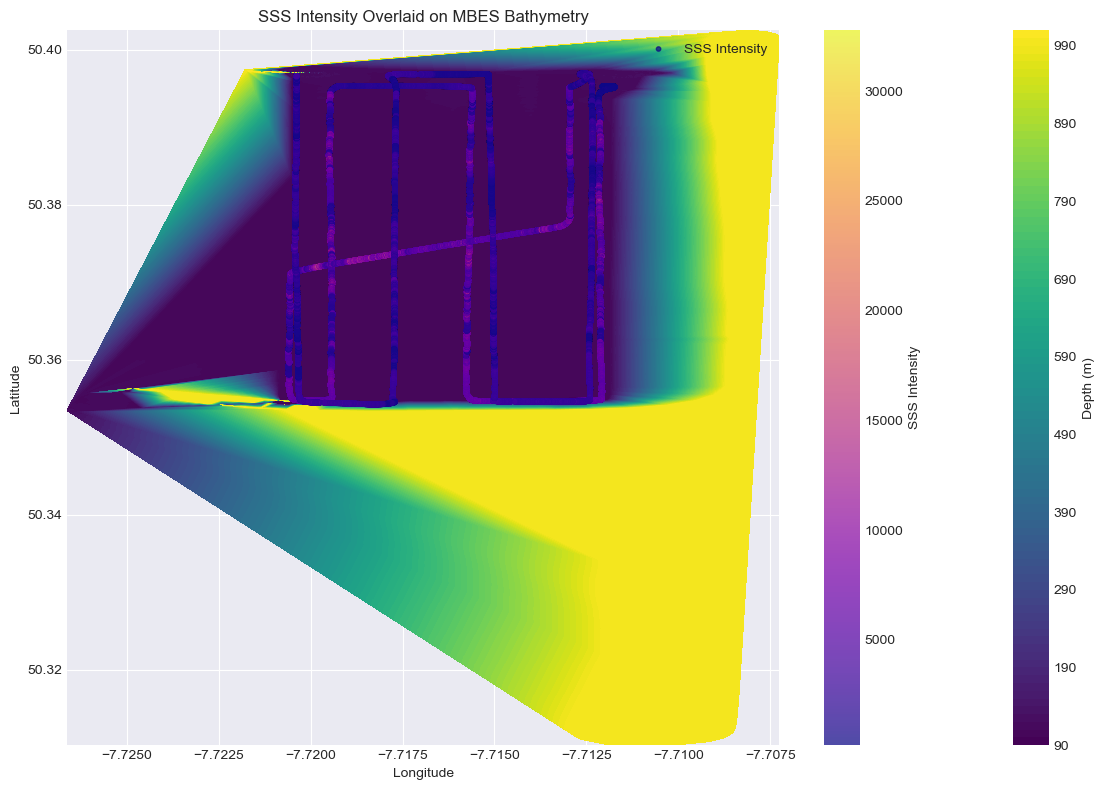

In [25]:
plt.figure(figsize=(12, 8))

# MBES bathymetry background (already loaded as `mbes_df`)
plt.tricontourf(mbes_df['Longitude'], mbes_df['Latitude'], mbes_df['seafloor_depth'], levels=100, cmap='viridis')
plt.colorbar(label='Depth (m)')

# Overlay SSS points
sc = plt.scatter(sss_df['lon'], sss_df['lat'], c=sss_df['intensity'], cmap='plasma', s=10, alpha=0.7, label='SSS Intensity')
plt.colorbar(sc, label='SSS Intensity')

# Labels and style
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('SSS Intensity Overlaid on MBES Bathymetry')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

---
### Filter SSS Points Within MBES Coverage Area

**Objective:** Select only the side-scan sonar (SSS) intensity points that fall within the geographical bounds of the MBES dataset.

**Method:** 
- Compute the bounding box (min/max latitude and longitude) from the MBES dataset.
- Use that box to filter the SSS dataset.
- This ensures we only work with sonar pings that intersect with MBES coverage.

**Result:** A filtered subset of the SSS data that is spatially relevant to the MBES area.


In [26]:
# Get MBES bounding box
lat_min, lat_max = mbes_df['Latitude'].min(), mbes_df['Latitude'].max()
lon_min, lon_max = mbes_df['Longitude'].min(), mbes_df['Longitude'].max()

# Filter SSS points within the MBES area
sss_filtered = sss_df[
    (sss_df['lat'] >= lat_min) & (sss_df['lat'] <= lat_max) &
    (sss_df['lon'] >= lon_min) & (sss_df['lon'] <= lon_max)
].copy()

print(f"Filtered SSS points: {len(sss_filtered)}")

Filtered SSS points: 259424


## Align MBES and SSS Points Using Nearest Neighbor (KDTree)

**Objective:** Spatially align the filtered SSS points with MBES points to extract corresponding depth values for each sonar ping.

**Method:** 
- Build a KDTree using the MBES lat/lon coordinates.
- For each SSS point, find the nearest MBES point within a small radius (e.g., ~50 meters).
- Extract the depth at that point and combine it with the SSS intensity.

**Result:** A new dataset where each SSS point has a matched depth from the MBES scan — ready for analysis or machine learning.

In [27]:
from scipy.spatial import cKDTree
import numpy as np

# Build KDTree for MBES coordinates
mbes_coords = np.vstack((mbes_df['Latitude'], mbes_df['Longitude'])).T
sss_coords = np.vstack((sss_filtered['lat'], sss_filtered['lon'])).T

tree = cKDTree(mbes_coords)

# Find nearest MBES point for each SSS point (within radius)
distances, indices = tree.query(sss_coords, distance_upper_bound=0.0005)  # ~50m

# Filter valid matches
valid = distances != np.inf
matched_sss = sss_filtered.iloc[valid].copy()
matched_mbes = mbes_df.iloc[indices[valid]].reset_index(drop=True)

# Create aligned dataset
aligned_data = matched_sss.reset_index(drop=True).copy()
aligned_data['seafloor_depth'] = matched_mbes['seafloor_depth'].values

# Final columns: lat, lon, depth, intensity
final_dataset = aligned_data[['lat', 'lon', 'seafloor_depth', 'intensity']]
print(final_dataset.head())

# Optional: export
final_dataset.to_csv("aligned_sss_mbes_dataset.csv", index=False)

         lat       lon  seafloor_depth  intensity
0  50.395279 -7.712078      110.413441      305.0
1  50.395289 -7.712059      116.440666      251.0
2  50.395289 -7.712059      116.440666      267.0
3  50.395289 -7.712059      116.440666      254.0
4  50.395289 -7.712059      116.440666      307.0


## Visualize Depth and Intensity Distributions

**Objective:** Explore how depth and sonar intensity values are distributed, and how they relate to each other.

**Method:** 
- Plot histograms of depth and intensity.
- Create a scatterplot of depth vs intensity.

**Insight:** These plots help identify patterns, correlations, and outliers. This step is useful before training models.

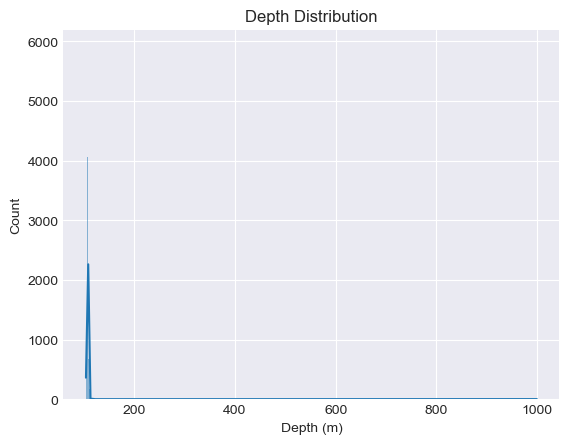

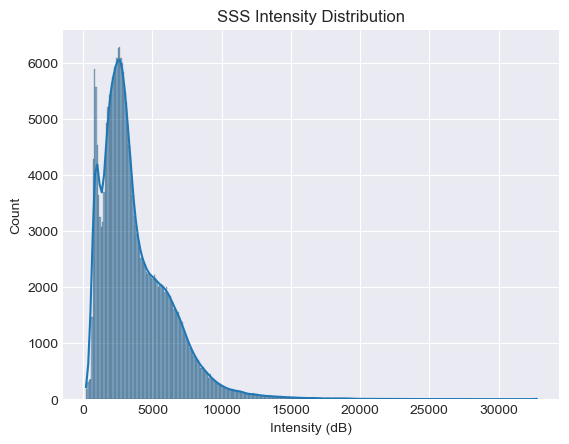

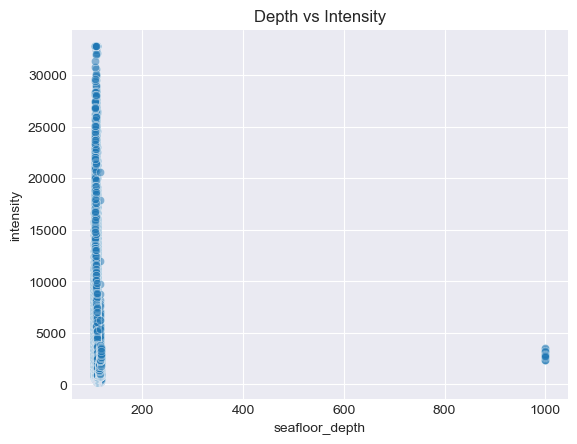

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution plots
sns.histplot(final_dataset['seafloor_depth'], kde=True)
plt.title("Depth Distribution")
plt.xlabel("Depth (m)")
plt.show()

sns.histplot(final_dataset['intensity'], kde=True)
plt.title("SSS Intensity Distribution")
plt.xlabel("Intensity (dB)")
plt.show()

# Scatterplot
sns.scatterplot(data=final_dataset, x='seafloor_depth', y='intensity', alpha=0.5)
plt.title("Depth vs Intensity")
plt.show()

## Summary of Preprocessing

- Parsed and visualized MBES navigation and bathymetric data.
- Clarified the distinction between AUV depth and actual seafloor depth.
- Cleaned and aligned SSS data for spatial correlation.
- Computed and visualized seafloor depth across the mission area.

## Normalize Features for Machine Learning

**Objective:** Standardize the depth and intensity values to have mean 0 and variance 1.

**Method:** Use `StandardScaler` from scikit-learn to normalize the data.

**Reason:** Most ML models benefit from normalized input features, improving convergence and performance.

**Result:** Adds `depth_norm` and `intensity_norm` columns, used in training.

In [29]:
from sklearn.preprocessing import StandardScaler

# Features to normalize
features = final_dataset[['seafloor_depth', 'intensity']].values
scaler = StandardScaler()
normalized = scaler.fit_transform(features)

# Add to DataFrame
final_dataset[['depth_norm', 'intensity_norm']] = normalized

C:\Users\perez\AppData\Local\Temp\ipykernel_21608\589615353.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dataset[['depth_norm', 'intensity_norm']] = normalized
C:\Users\perez\AppData\Local\Temp\ipykernel_21608\589615353.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_dataset[['depth_norm', 'intensity_norm']] = normalized


## Split Dataset for Model Training

**Objective:** Divide the data into training, validation, and testing subsets.

**Method:** 
- Use `train_test_split` with a 70/15/15 split.
- Ensure that the model generalizes well to unseen data.

**Result:** Creates 3 distinct sets to train, tune, and evaluate machine learning models.

In [30]:
from sklearn.model_selection import train_test_split

# Let's use normalized values for ML
X = final_dataset[['depth_norm', 'intensity_norm']].values
y = final_dataset[['seafloor_depth', 'intensity']].values  # or any label later

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Train set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")
print(f"Test set: {len(X_test)} samples")

Train set: 181596 samples
Validation set: 38914 samples
Test set: 38914 samples


## Save Processed Dataset for Future Use

**Objective:** Save the aligned and normalized dataset, as well as the scaler, so you can use it later in notebooks or models.

**Method:** 
- Save arrays using `np.savez`.
- Save the scaler using `joblib`.

**Result:** Ready-to-train dataset is now available in disk-friendly format.


In [31]:
# Save normalized & split data
np.savez("ml_dataset.npz",
         X_train=X_train, y_train=y_train,
         X_val=X_val, y_val=y_val,
         X_test=X_test, y_test=y_test)

# Save scaler to use later during inference
import joblib
joblib.dump(scaler, "scaler.pkl")


['scaler.pkl']